In [9]:
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [30]:
import random
class QuadraticSampleGenerator:
    
    def __init__(self, total_samples, signal_len, show_imgs):
        self.total_samples = total_samples
        self.signal_len = signal_len
        self.show_imgs = show_imgs
    
    def quadratic(self, x):
        signal_len = self.signal_len
        h = random.randint(0, int(signal_len*.1))
        y = x*x+h
        return y
    
    def add_gaussian_noise(self): # mean, standard deviation and output shape
        mu, sigma = 0, np.std(self.ys)*2
        gaussian_noise = np.random.normal(mu, sigma, len(self.ys))
        return gaussian_noise
    
    def generate_sample(self):
        signal_len = self.signal_len
        half_len = int(signal_len/2)
        remaining = signal_len%2
        
        xs = []
        ys = []
        start = -half_len
        
        if remaining!=0:
            end = half_len+1
        else:
            end = half_len
            
        for i in range(start, end, 1):
            y = self.quadratic(i)
            xs.append(i)
            ys.append(y)
        
        xs = np.array(xs)
        ys = np.array(ys)
        
        self.xs = xs
        self.ys = ys 
        
        
    def plot_a_signal(self):
        plt.plot(self.xs, self.ys)
        plt.show()
        
    def standardization(self, sample_ys):
        scaler = StandardScaler()
        scaler.fit(sample_ys)
        standardized_sample_ys = scaler.transform(sample_ys)
        return standardized_sample_ys
        
        
        
    def generate_many_samples(self):
        total_samples = self.total_samples
        sample_ys = []
        sample_labels = []
        shapes = ['convex', 'concave']
        
        for i in range(total_samples):
            self.generate_sample()
            gaussian_noise = self.add_gaussian_noise()
            smooth_noise = gaussian_filter(gaussian_noise, sigma=100)
            
            shape_decision = random.choice(shapes)
            if shape_decision == 'convex':
                self.ys = self.ys+ smooth_noise
                sample_labels.append(0)
            else:
                self.ys = -self.ys-smooth_noise
                sample_labels.append(1)
            
            sample_ys.append(self.ys)
            
            if self.show_imgs:
                self.plot_a_signal()
            
        standardized_sample_ys = self.standardization(sample_ys)
        
        
        return standardized_sample_ys, sample_labels
        
        
        
        
        

# vidualize some samples

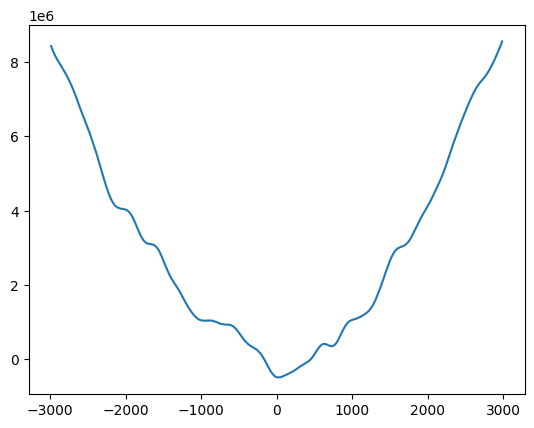

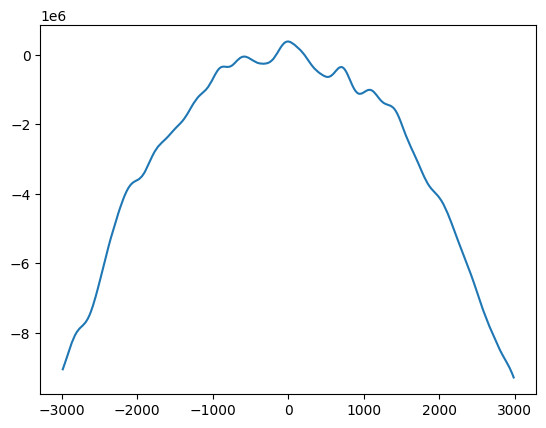

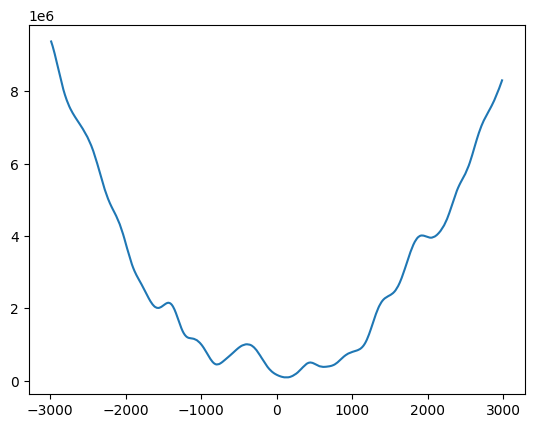

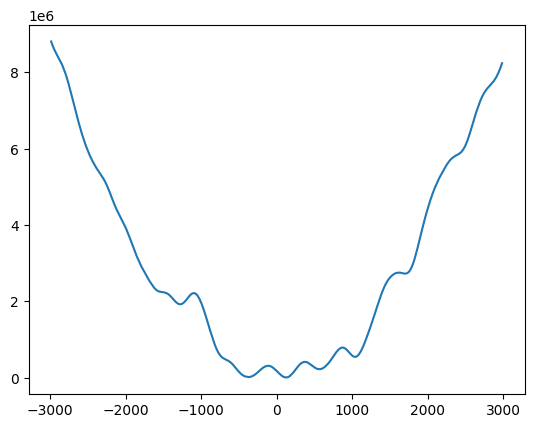

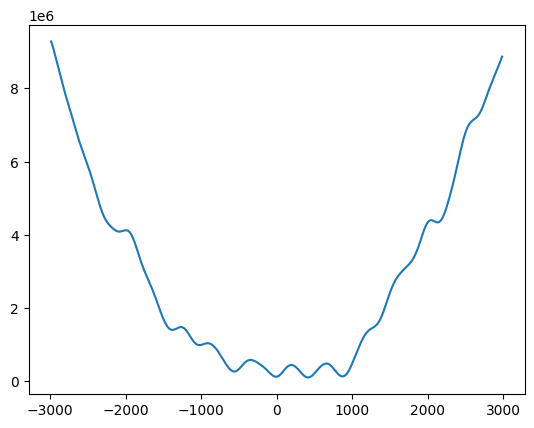

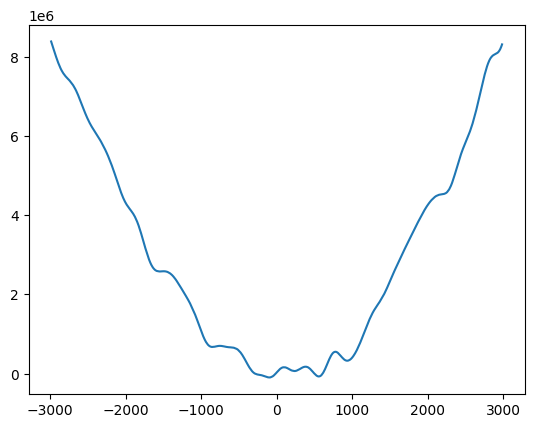

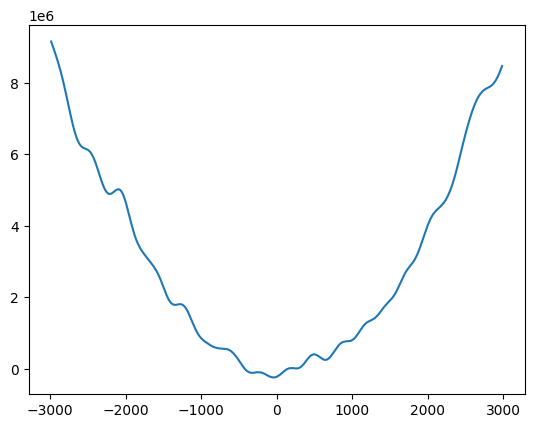

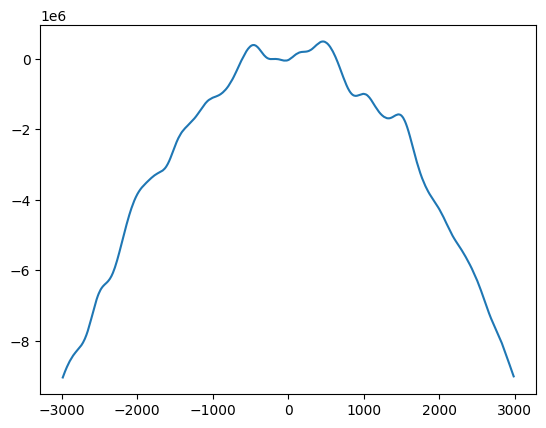

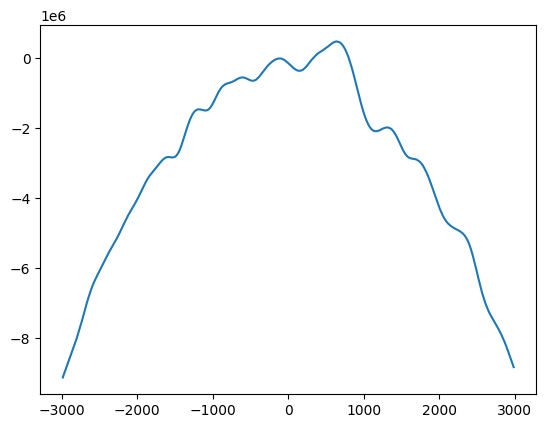

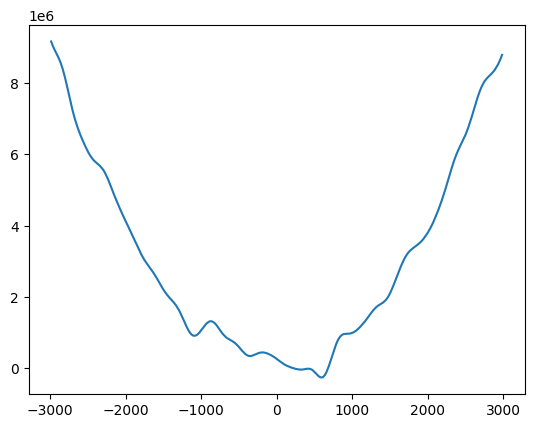

In [67]:
total_samples, signal_len = 10, 5976
show_imgs = True
Quad = QuadraticSampleGenerator(total_samples, signal_len, show_imgs)
unseen_ys, unseen_labels = Quad.generate_many_samples()

# Train a 1dcnn model 

In [39]:
total_samples, signal_len = 3000, 5976
show_imgs = False
Quad = QuadraticSampleGenerator(total_samples, signal_len, show_imgs)
sample_ys, sample_labels = Quad.generate_many_samples()

In [44]:
sample_ys = np.stack(sample_ys, axis=0)
sample_labels = np.array(sample_labels)
sample_labels = np.expand_dims(sample_labels, axis=1)

In [49]:
import pandas as pd
data = pd.DataFrame(sample_ys)
labels = pd.DataFrame(sample_labels)
print(data.shape, labels.shape)

(3000, 5976) (3000, 1)


In [50]:
from das_lib.models import cnn1d
import tensorflow as tf

2023-07-19 20:47:18.715640: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [51]:
import random
def split_train_test_1d(data, labels, frac=.8, index=None):
    x_train = data.sample(frac=frac) if index is None else data.iloc[index]
    x_test = data.drop(x_train.index)
    y_train = labels.iloc[x_train.index]
    y_test = labels.drop(x_train.index)
    return x_train, x_test, y_train, y_test, x_train.index

In [52]:
num_classes = 2
x_train, x_test, y_train, y_test, x_train_index = split_train_test_1d(data, labels, frac=.67, index=None)
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [53]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2010, 5976, 1), (990, 5976, 1), (2010, 2), (990, 2))

In [54]:
m = cnn1d( (x_train.shape[1],1), y_train.shape[1])
print(m.summary())

2023-07-19 20:49:08.702140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 20:49:10.467498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d8:00.0, compute capability: 8.0


Model: "1dcnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5976, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2957, 16)          1040      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 369, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 169, 32)           16416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 21, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 16)             

In [55]:
H = m.fit(x_train, y_train, epochs=1000, batch_size=64, validation_data=(x_test, y_test), verbose=False)
m.evaluate(x_test, y_test, batch_size=64, verbose=True)

2023-07-19 20:49:25.180414: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-07-19 20:49:31.363684: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [56]:
checkpoint_folder = 'training_results'
model_name = 'convex_concave_classification'
checkpoint_path = checkpoint_folder+'/'+'{0}'.format(model_name)
m.save(checkpoint_path)

INFO:tensorflow:Assets written to: training_results/convex_concave_classification/assets


INFO:tensorflow:Assets written to: training_results/convex_concave_classification/assets


# Test unseen dataset

In [63]:
total_samples, signal_len = 100, 5976
show_imgs = False
Quad = QuadraticSampleGenerator(total_samples, signal_len, show_imgs)
unseen_ys, unseen_labels = Quad.generate_many_samples()

In [64]:
unseen_ys = np.stack(unseen_ys, axis=0)
unseen_labels = np.array(unseen_labels)
unseen_labels = np.expand_dims(unseen_labels, axis=1)

In [65]:
x_unseen = np.expand_dims(unseen_ys,-1)
y_unseen = tf.keras.utils.to_categorical(unseen_labels, num_classes)
print(x_unseen.shape, y_unseen.shape)

(100, 5976, 1) (100, 2)


In [66]:
m.evaluate(x_test_ys, y_test_labels, batch_size=64, verbose=True)

2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]